<div  >
<img src="https://raw.githubusercontent.com/threeML/astromodels/master/docs/media/transp_logo.png" alt="drawing" width="300" align="right"/>
 


<div  >
<img src="https://raw.githubusercontent.com/threeML/threeML/master/logo/logo_sq.png" alt="drawing" width="300" align="right"/>



# X-ray Analysis with 3ML
    
While 3ML can handle a lot of different data/likelihood types a lot of attention was spent on making sure that users familiar with past community standards are able to easily adapt to the 3ML workflow. There are some guides for these users in the [documentation](https://threeml.readthedocs.io/en/stable/xspec_users.html).
    
X-ray analysis in 3ML is centered around the `OGIPLike` plugin which reads OGIP style PHAI/II, RMF, and ARF files. the OGIPLike plugin is a specialized version of the `DispersionSpectrumLike` plugin which deals with count data that are produced by convolving the model spectrum with the resonse of an instrument that suffers from energy dispersion. Thus, if you have an instrument you are designing and you don't like fits files... inherit from DispersionSpectrumLike and create your own unique plugin for ROOT, HDF5, txt, etc. files. The cool thing is that you can still fit your data along with normal OGIP type data... or any of the other plugins in the 3ML family. 3ML is a toolbox to bring instruments (and people) together. 
    
    
Let's explore the OGIPLike plugin

 


## The OGIPLike plugin

The OGIP plugin reads in standard OGIP files. **It will complain a lot if files are in the correct format!**. For PHAII files with multiple spectra, you can use the familiar `<filename>{<spectrum_number>}` format to specify file names or you can pass a spectrum number as an argument. 

<img src="https://cdn.pixabay.com/photo/2012/11/28/11/16/star-67705_960_720.jpg" alt="drawing" width="400" align="center"/>


In the tutorial, there are some simulated Chandra data. Let's say that these data come from the observation of a a white drawf atmosphere. Let's see what we can do with these data.


In [128]:
from threeML import *
update_logging_level("INFO")
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)


In [87]:
chandra = OGIPLike(name="chandra", 
                   observation="c_data/obs.pha", 
                   background="c_data/obs_bak.pha",
                   response="c_data/acis.rmf",
                   arf_file="c_data/acis.arf",
                   spectrum_number=1 )

[WARNING ] Maximum MC energy (12.0) is smaller than maximum EBOUNDS energy (14.950400352478027)
[WARNING ] Minimum MC energy (0.2549999952316284) is larger than minimum EBOUNDS energy (0.007300000172108412)
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson


Note that 3ML probed the type of data that were read in. As long as the data files have been appropriately labelled, the plugin will **choose the correct likelihood for you**. While freedom is a great thing, math is not a democracy and thus we follow the rules so that your fits are of the highest scientific rigour. 

In this case, the total observation and the background observation are Poisson distributed. Thus, the proper likelihood is a Poisson for the total observation conditional ont he Poisson likelihood of the background. For now, we will not model the background. Therefore a profile likelihood will be choosen.

Let's examine the properties of the plugin.


In [88]:
chandra.significance

13.003882717331802

In [89]:
chandra.significance_per_channel

array([-0.25829467, -0.82437622, -0.        , ...,         nan,
       -0.        , -0.        ])

<IPython.core.display.Javascript object>


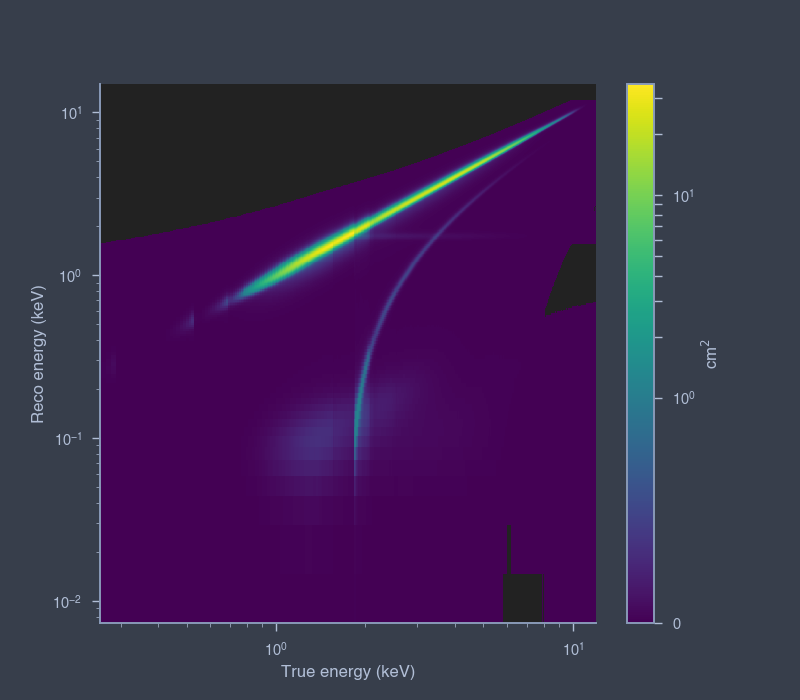


WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



In [129]:
chandra.display_rsp()

In [91]:
chandra.exposure

1.0

<IPython.core.display.Javascript object>


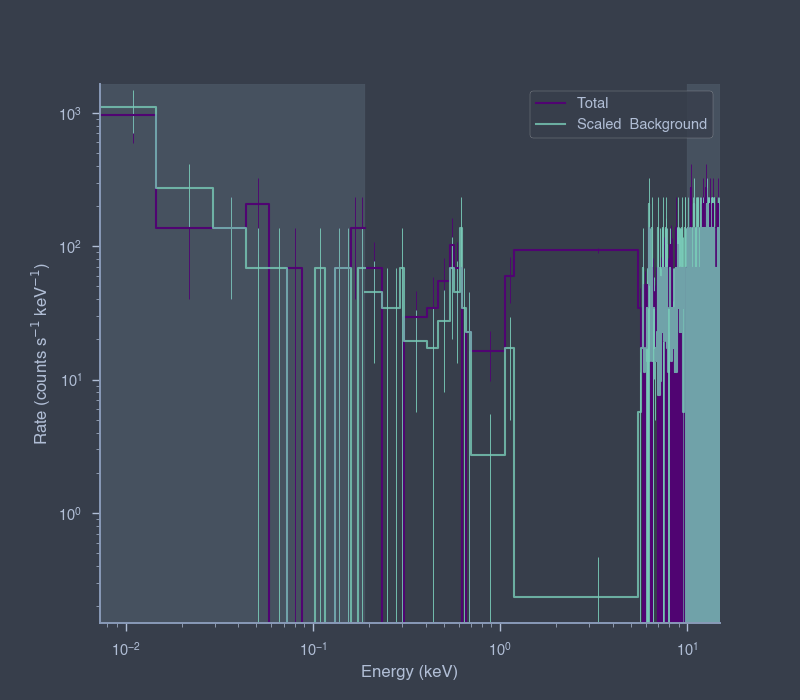


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [130]:
chandra.view_count_spectrum();

Now, not all channels are great to use in an analysis. Thus, we can set our selections.

In [48]:
chandra.set_active_measurements?

In [93]:
chandra.set_active_measurements('0.2-10')

[INFO    ] Range 0.2-10 translates to channels 13-684


<IPython.core.display.Javascript object>


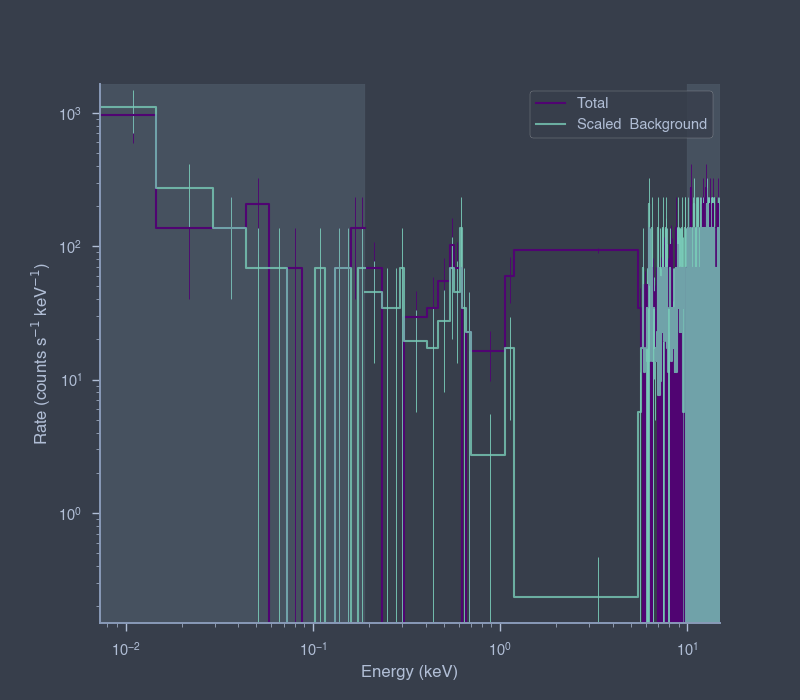


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [131]:
chandra.view_count_spectrum();

For profile likelihoods to valid, there must be at least 1 [background count per channel](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/). Let's do that here:

In [95]:
chandra.rebin_on_background(1)
#chandra.remove_rebinning()

[INFO    ] Now using 121 bins


<IPython.core.display.Javascript object>


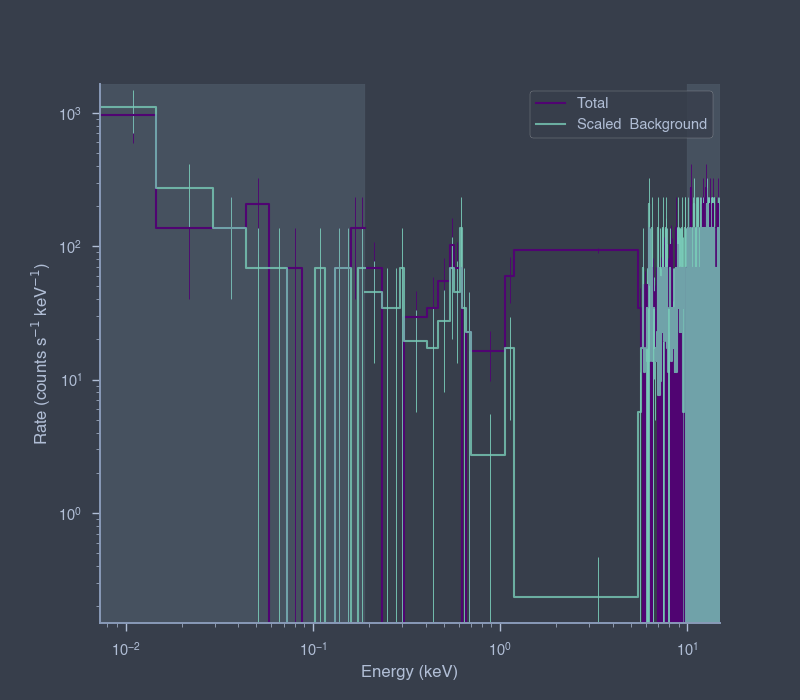


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [132]:
chandra.view_count_spectrum();

## Fitting 

Ok, we are basically ready to do a fit. But we need a model. Let's make two models, one of a black body and the other a power law. We are going to be Bayesians for now, but remember, there is little difference between the interface for the two approaches.

### blackbody model


In [122]:
bb = Blackbody()

#priors
bb.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 10)
bb.kT.prior = Truncated_gaussian(mu= 5, sigma=5, lower_bound=0, upper_bound=np.inf)

# source
ps_bb = PointSource("white_drawf_bb", 0, 0, spectral_shape=bb)

# model
model_bb = Model(ps_bb)

In [126]:
bayes_bb = BayesianAnalysis(model_bb, DataList(chandra))

# let's use ultranest this time
bayes_bb.set_sampler("ultranest")

bayes_bb.sampler.setup(min_num_live_points=400)

_ = bayes_bb.sample()

[WARNING ] External parameter cons_chandra already exist in the model. Overwriting it...
[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+02  .55 [-299.5589..-299.5588]*| it/evals=5000/9394 eff=55.5926% N=400 0 0  
[ultranest] Likelihood function evaluations: 9439
[ultranest]   logZ = -307.5 +- 0.1053
[ultranest] Effective samples strategy satisfied (ESS = 1605.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.24, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_bb.spectrum.main.Blackbody.K,(7.6 +/- 2.8) x 10^-1,1 / (cm2 keV3 s)
white_drawf_bb.spectrum.main.Blackbody.kT,1.03 +/- 0.13,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-300.551286
total,-300.551286



Values of statistical measures:



,statistical measures
AIC,605.120508
BIC,614.123088
DIC,600.377643
PDIC,-2.757977
log(Z),-133.556774


<IPython.core.display.Javascript object>


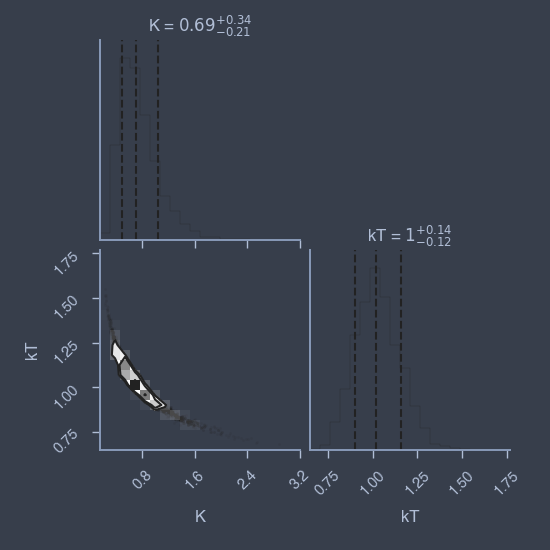

In [148]:
bayes_bb.results.corner_plot();

<IPython.core.display.Javascript object>


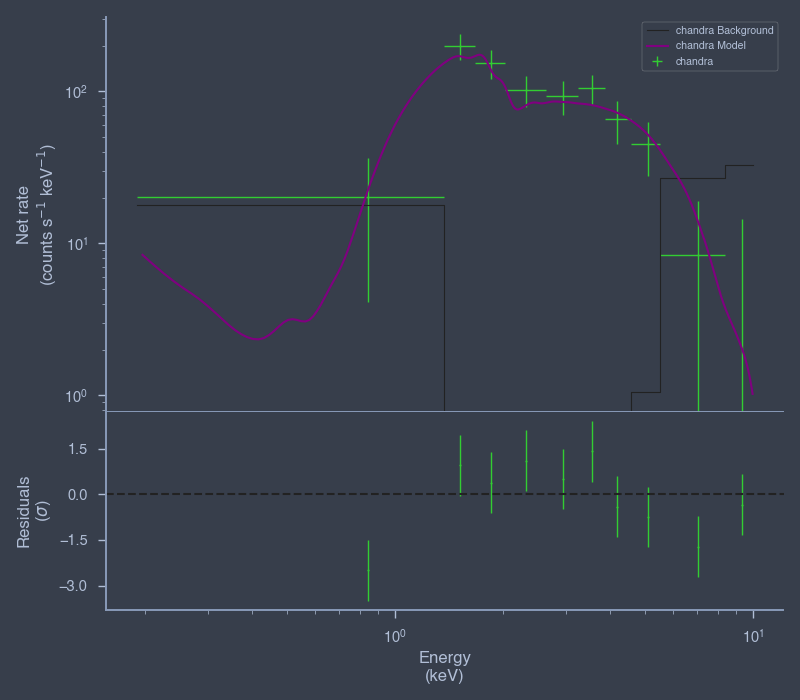


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [133]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=50,
                              show_background=True);



In [ ]:
show_configuration('plugins')

In [135]:
threeML_config.plugins.ogip.fit_plot.data_color = 'limegreen'
threeML_config.plugins.ogip.fit_plot.model_color = '#FF5AFD'

<IPython.core.display.Javascript object>


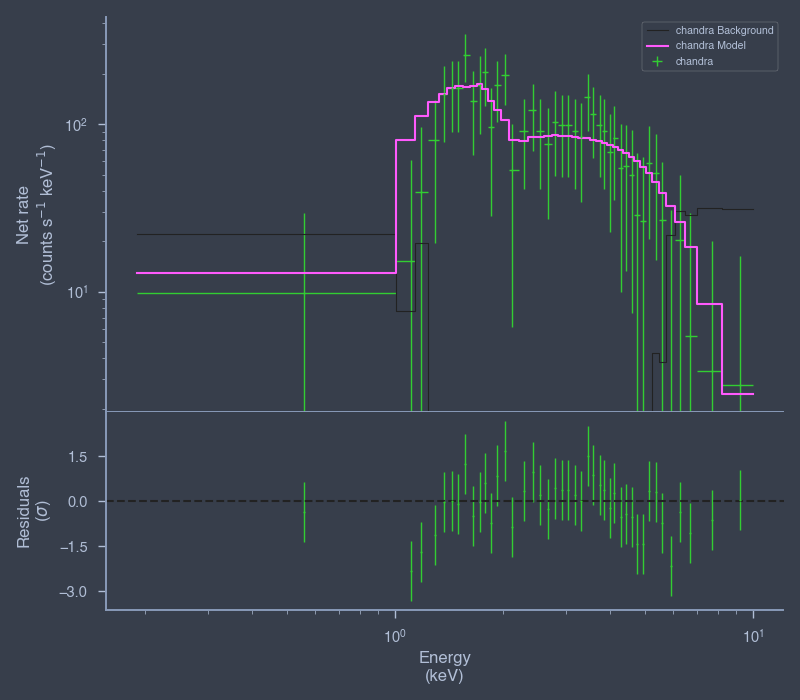


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [145]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=10,
                              step=True,
                              show_background=True);




### power law model

In [124]:
plaw = Powerlaw()

plaw.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 10) 

plaw.index.prior = Gaussian(mu=-1, sigma=2)
plaw.index.bounds = (None, None)


# source
ps_pl = PointSource("white_drawf_pl", 0, 0, spectral_shape=plaw)

# model
model_pl = Model(ps_pl)

In [127]:
bayes_pl = BayesianAnalysis(model_pl, DataList(chandra))

# let's use ultranest this time
bayes_pl.set_sampler("ultranest")

bayes_pl.sampler.setup(min_num_live_points=400)

_ = bayes_pl.sample()

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+02  .95 [-307.9601..-307.9601]*| it/evals=4410/6344 eff=74.1925% N=400 400  
[ultranest] Likelihood function evaluations: 6376
[ultranest]   logZ = -314.4 +- 0.07648
[ultranest] Effective samples strategy satisfied (ESS = 1584.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_pl.spectrum.main.Powerlaw.K,(8.0 -1.4 +1.3) x 10^-1,1 / (cm2 keV s)
white_drawf_pl.spectrum.main.Powerlaw.index,(-9.8 +/- 1.7) x 10^-1,



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-308.546731
total,-308.546731



Values of statistical measures:



,statistical measures
AIC,621.111399
BIC,630.113978
DIC,620.990224
PDIC,1.914503
log(Z),-136.560562


<IPython.core.display.Javascript object>


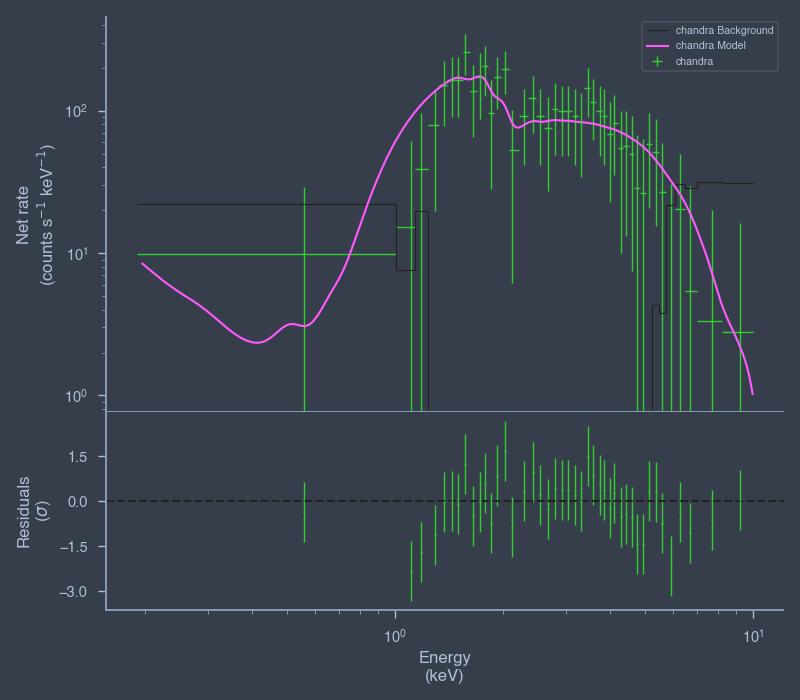


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [139]:
display_spectrum_model_counts(bayes_pl,
                              min_rate=10,
                              show_background=True);

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


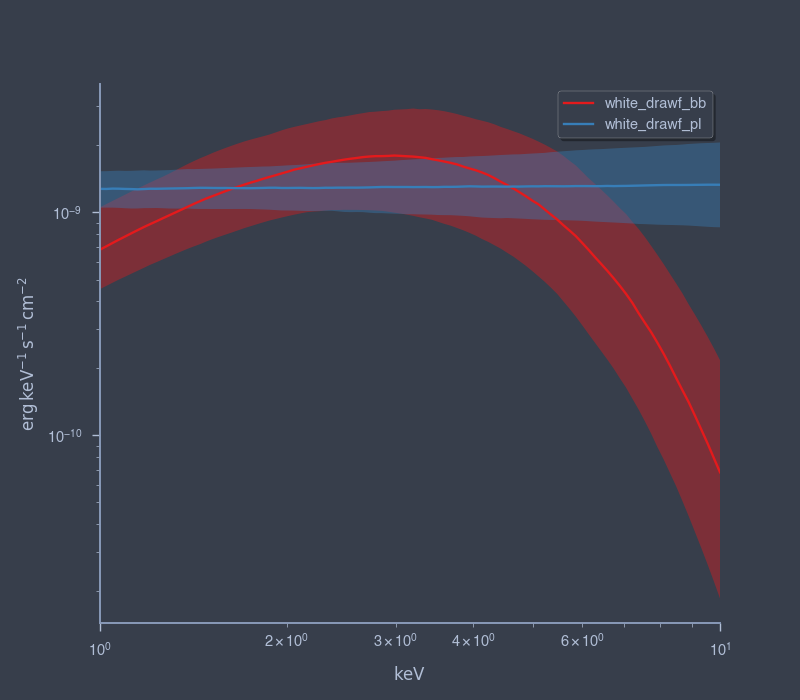

In [143]:
plot_spectra(bayes_bb.results, bayes_pl.results,
             flux_unit="erg/(cm2 s keV)",
             ene_min=1*u.keV, ene_max=10*u.keV);

## posterior predictive checks (PPC)

Let's use an external package to 3ML (but built with its tools box!) to compute posterior predictive checks. PPCs are model checking tool that integrate over the posterior and likelihood to compute the probability of new data from the observed data. We can compute this via simulating new data from the likelihood for sampled points from our posterior. A more detailed explanation for this can be found [here](https://academic.oup.com/mnras/article/490/1/927/5570608).

In [86]:
from twopc import compute_ppc

[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson


In [150]:
ppc_bb = compute_ppc(bayes_bb,
                  bayes_bb.results,
                  n_sims=500,
                  file_name="ppc_bb.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


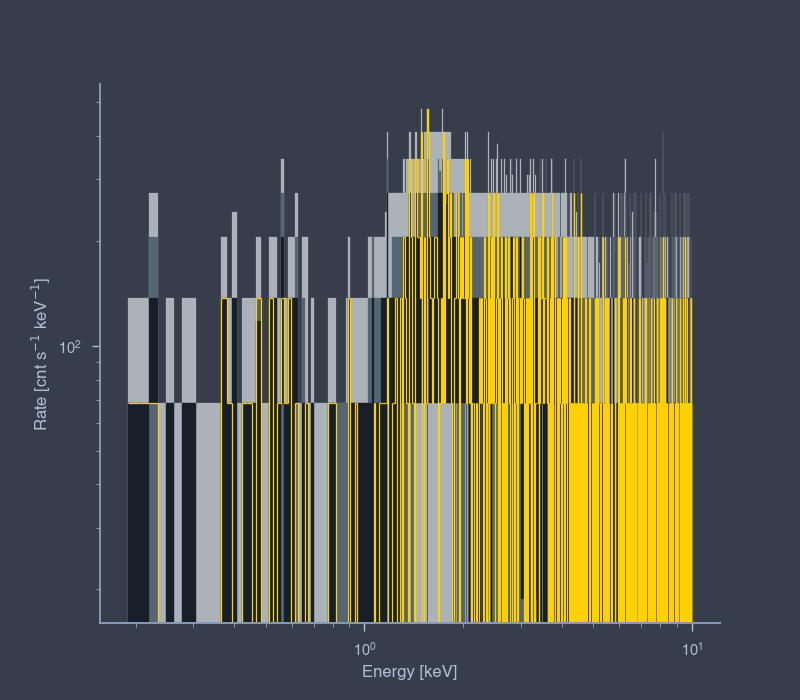

In [152]:
ppc_bb.chandra.plot();

<IPython.core.display.Javascript object>


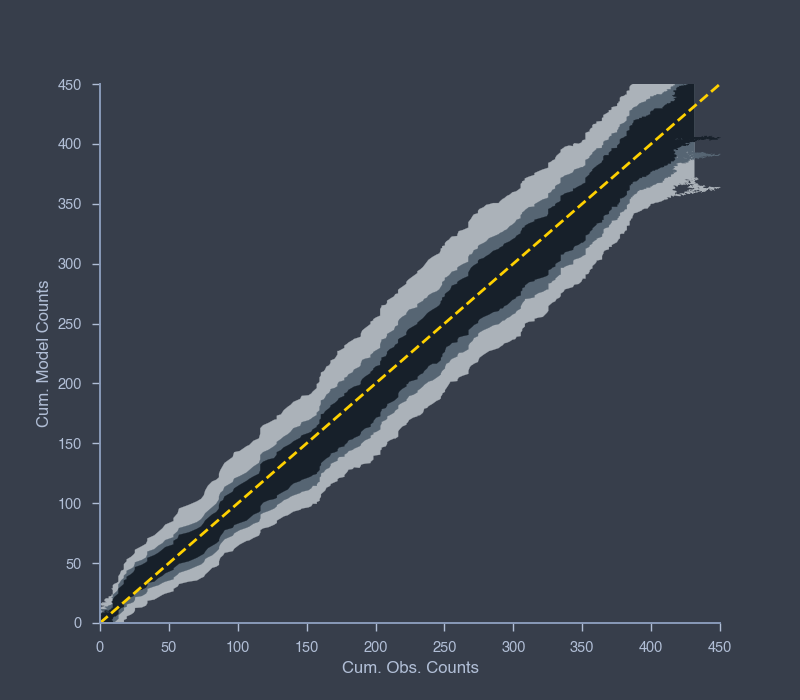

In [160]:
ppc_bb.chandra.plot_qq(channel_energies=None);

In [151]:
ppc_pl = compute_ppc(bayes_pl,
                  bayes_pl.results,
                  n_sims=500,
                  file_name="ppc_pl.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


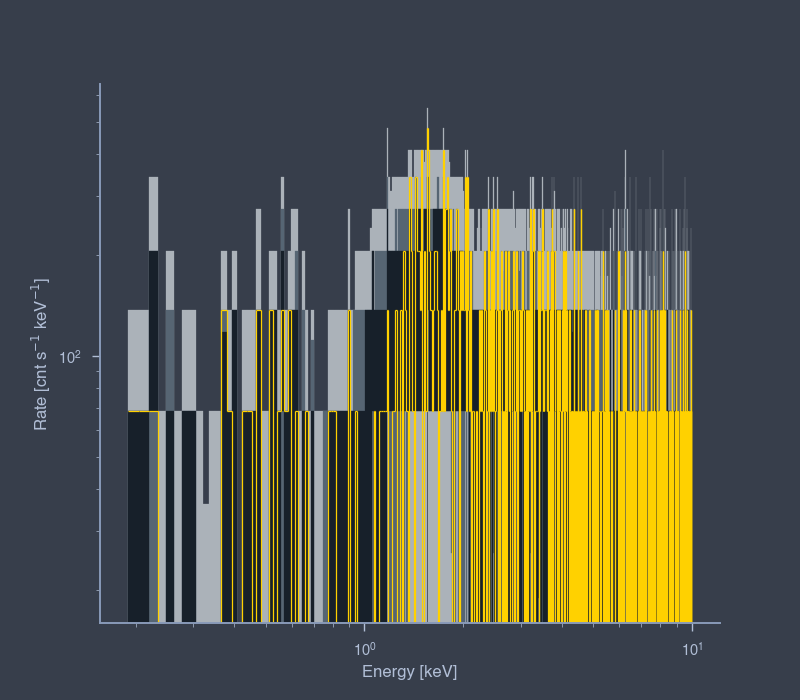

In [161]:
ppc_pl.chandra.plot();

<IPython.core.display.Javascript object>


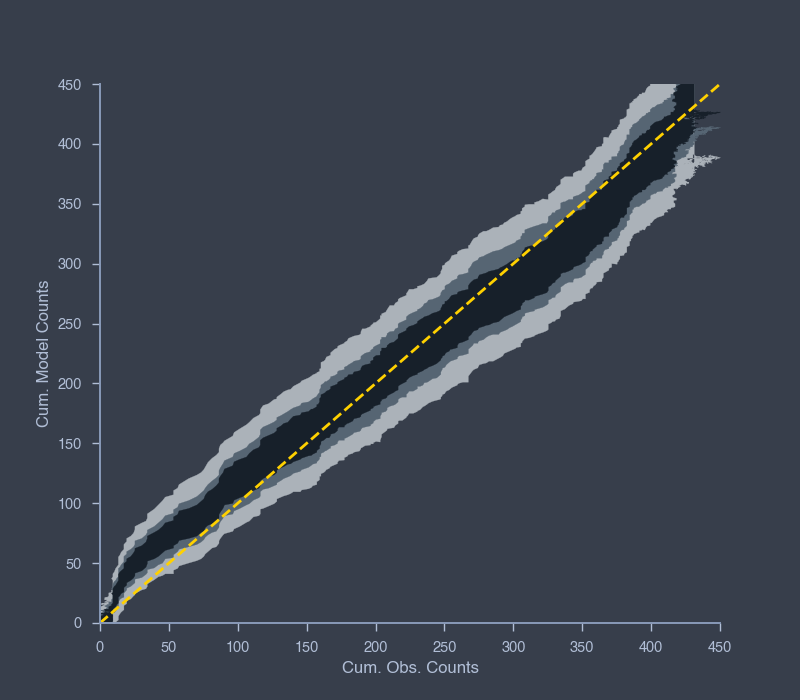

In [162]:
ppc_pl.chandra.plot_qq(channel_energies=None);

The OGIP plugin (or any plugin) is not just for fitting, it can be used as a generic interface between models and isntruments for building pipelines. 
* Plugins and models are serializable meaning they can be farmed out to multi-processing
* Most plugins can simulate data from their likelihoods (complex instruments still need some work here)

Let's try this out:

<IPython.core.display.Javascript object>


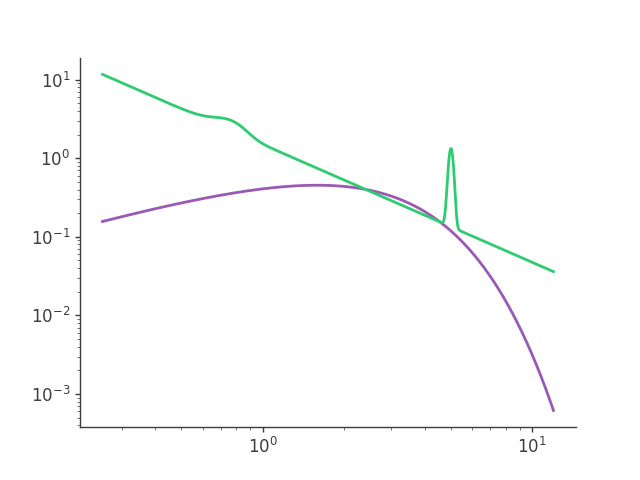

In [84]:
bb =  Blackbody(K=.7,kT = 1.)


bkg = Powerlaw(K=1.5,index=-1.5) + Gaussian(F=.2, mu=0.75, sigma=.1) + Gaussian(F=.3, mu=5, sigma=.1)

xx= rsp.monte_carlo_energies

fig, ax = plt.subplots()

ax.loglog(xx, bb(xx))
ax.loglog(xx, bkg(xx))


geb = DispersionSpectrumLike.from_function('gen',source_function=bb, response=rsp, background_function=bkg)
geb.write_pha("c_data/obs", overwrite=True)